In [1]:
import torch
from torch.utils.data import  DataLoader,TensorDataset
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
from sklearn.model_selection import train_test_split
import category_encoders as ce
import torch

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.metrics import r2_score
import numpy as np
import os
from sklearn.model_selection import GridSearchCV
import xgboost as xg
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_excel("house_price_without_categorical.xlsx",index_col=0)

In [3]:
categorical_columns = ['Neighborhood',"District","Usage","Heat_type","Floor"]

In [4]:
Y = df["Price"].values

# Drop the target column from the input features
X = df.drop(columns=["Price"])

In [5]:
df

,District,Neighborhood,Num_Of_Room,Area,Floor,Age,Heat_type,Apt_Floor,Credit_Eli,Items,Num_of_Bath,Usage,Price
0,Gölbaşı,Hacılar,9,550.0,first floor,4,Kombi,3,1,0,6,Boş,17700000
1,Keçiören,Etlik,4,145.0,interstage,16,Kombi,4,1,0,2,Boş,2790000
2,Çankaya,Birlik,8,340.0,interstage,18,Kombi,4,1,0,3,Boş,4450000
3,Keçiören,Etlik,4,110.0,basement,25,Kombi,3,1,0,1,Mülk Sahibi,1249000
4,Çankaya,Keklik Pınarı,4,120.0,interstage,26,Kombi,10,1,0,1,Boş,2445000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20055,Çankaya,Emek,6,180.0,top floor,25,Kombi,4,1,1,1,Boş,4500000
20056,Polatlı,Zafer,7,340.0,top floor,11,Kombi,4,1,0,2,Mülk Sahibi,1395000
20057,Çankaya,Yıldızevler,4,155.0,interstage,23,Merkezi,4,1,0,2,Boş,4750000
20058,Keçiören,Bağlarbaşı,5,215.0,interstage,8,Kombi,10,1,0,2,Boş,4250000


In [6]:
# Calculate Q1, Q3, and IQR
Q1 = np.percentile(Y, 25)
Q3 = np.percentile(Y, 75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a boolean mask to identify outliers
mask = (Y > lower_bound) & (Y < upper_bound)

# Filter the DataFrame using the mask
df_filtered = df[mask]

In [7]:
df_filtered

,District,Neighborhood,Num_Of_Room,Area,Floor,Age,Heat_type,Apt_Floor,Credit_Eli,Items,Num_of_Bath,Usage,Price
1,Keçiören,Etlik,4,145.0,interstage,16,Kombi,4,1,0,2,Boş,2790000
2,Çankaya,Birlik,8,340.0,interstage,18,Kombi,4,1,0,3,Boş,4450000
3,Keçiören,Etlik,4,110.0,basement,25,Kombi,3,1,0,1,Mülk Sahibi,1249000
4,Çankaya,Keklik Pınarı,4,120.0,interstage,26,Kombi,10,1,0,1,Boş,2445000
5,Çankaya,Emek,5,147.0,interstage,30,Merkezi,11,1,0,1,Kiracılı,4100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20055,Çankaya,Emek,6,180.0,top floor,25,Kombi,4,1,1,1,Boş,4500000
20056,Polatlı,Zafer,7,340.0,top floor,11,Kombi,4,1,0,2,Mülk Sahibi,1395000
20057,Çankaya,Yıldızevler,4,155.0,interstage,23,Merkezi,4,1,0,2,Boş,4750000
20058,Keçiören,Bağlarbaşı,5,215.0,interstage,8,Kombi,10,1,0,2,Boş,4250000


In [8]:
Y = df_filtered["Price"]

# Drop the target column from the input features
X = df_filtered.drop(columns=["Price"])

In [9]:
X

,District,Neighborhood,Num_Of_Room,Area,Floor,Age,Heat_type,Apt_Floor,Credit_Eli,Items,Num_of_Bath,Usage
1,Keçiören,Etlik,4,145.0,interstage,16,Kombi,4,1,0,2,Boş
2,Çankaya,Birlik,8,340.0,interstage,18,Kombi,4,1,0,3,Boş
3,Keçiören,Etlik,4,110.0,basement,25,Kombi,3,1,0,1,Mülk Sahibi
4,Çankaya,Keklik Pınarı,4,120.0,interstage,26,Kombi,10,1,0,1,Boş
5,Çankaya,Emek,5,147.0,interstage,30,Merkezi,11,1,0,1,Kiracılı
...,...,...,...,...,...,...,...,...,...,...,...,...
20055,Çankaya,Emek,6,180.0,top floor,25,Kombi,4,1,1,1,Boş
20056,Polatlı,Zafer,7,340.0,top floor,11,Kombi,4,1,0,2,Mülk Sahibi
20057,Çankaya,Yıldızevler,4,155.0,interstage,23,Merkezi,4,1,0,2,Boş
20058,Keçiören,Bağlarbaşı,5,215.0,interstage,8,Kombi,10,1,0,2,Boş


In [10]:
encoder = ce.TargetEncoder(cols=categorical_columns)
X_encoded = encoder.fit_transform(X, Y)


In [11]:
X_encoded

,District,Neighborhood,Num_Of_Room,Area,Floor,Age,Heat_type,Apt_Floor,Credit_Eli,Items,Num_of_Bath,Usage
1,1.869813e+06,1.992179e+06,4,145.0,2.168055e+06,16,1.841436e+06,4,1,0,2,2.003629e+06
2,2.574058e+06,2.846984e+06,8,340.0,2.168055e+06,18,1.841436e+06,4,1,0,3,2.003629e+06
3,1.869813e+06,1.992179e+06,4,110.0,1.286913e+06,25,1.841436e+06,3,1,0,1,2.039964e+06
4,2.574058e+06,2.481640e+06,4,120.0,2.168055e+06,26,1.841436e+06,10,1,0,1,2.003629e+06
5,2.574058e+06,2.931228e+06,5,147.0,2.168055e+06,30,2.572097e+06,11,1,0,1,1.975982e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
20055,2.574058e+06,2.931228e+06,6,180.0,2.067276e+06,25,1.841436e+06,4,1,1,1,2.003629e+06
20056,1.099797e+06,1.136295e+06,7,340.0,2.067276e+06,11,1.841436e+06,4,1,0,2,2.039964e+06
20057,2.574058e+06,2.598996e+06,4,155.0,2.168055e+06,23,2.572097e+06,4,1,0,2,2.003629e+06
20058,1.869813e+06,1.502789e+06,5,215.0,2.168055e+06,8,1.841436e+06,10,1,0,2,2.003629e+06


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded.values, Y.values, test_size=0.2, random_state=42)

In [14]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler(feature_range=(0,1))
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
Y_train_scaled = scaler_Y.fit_transform(y_train.reshape(-1,1))
Y_test_scaled = scaler_Y.transform(y_test.reshape(-1,1))

In [15]:
Y_train_scaled

array([[0.59006203],
       [0.43478249],
       [0.3312628 ],
       ...,
       [0.31055886],
       [0.28778453],
       [0.5983436 ]])

In [16]:
X_train_tensor = torch.from_numpy(X_train_scaled).float()
y_train_tensor = torch.from_numpy(Y_train_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()
y_test_tensor = torch.from_numpy(Y_test_scaled).float()

In [17]:
y_test_tensor = y_test_tensor.squeeze(1)


In [18]:
y_test_tensor

tensor([0.2795, 0.4037, 0.3518,  ..., 0.9265, 0.1418, 0.5383])

In [41]:
X_train_tensor.shape

torch.Size([15183, 12])

In [19]:
y_train_tensor = y_train_tensor.squeeze(1)

In [20]:
y_train_tensor

tensor([0.5901, 0.4348, 0.3313,  ..., 0.3106, 0.2878, 0.5983])

In [21]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)




In [42]:
class AdaptiveRelu(torch.nn.Module):
    def __init__(self, init_alpha =0.9, init_beta=0.1):
        super(AdaptiveRelu, self).__init__()
        self.alpha = torch.nn.Parameter(torch.tensor(init_alpha))
        self.beta = torch.nn.Parameter(torch.tensor(init_beta))
    def forward(self, x):
        return torch.tanh(self.alpha*x + self.beta) 



class Net(nn.Module):
    def __init__(self,L1,L2,L3,L4):
        super(Net,self).__init__()
  
        self.layers = nn.Sequential(
      nn.Linear(12,L1),
      AdaptiveRelu(),
      nn.Linear(L1,L2),
      AdaptiveRelu(),
      nn.Linear(L2,L3),
      AdaptiveRelu(),
      nn.Linear(L3,L4),
      AdaptiveRelu(),
      nn.Linear(L4,1),
    )
    def forward(self, x):
        return self.layers(x)

In [43]:
def train(dataloader,model,loss_fn,optimizer):
    
    model.train()
    running_loss = 0

    for batch,(x,y) in enumerate(dataloader):

        
        
        optimizer.zero_grad()
        output = model(x) 
        loss   = loss_fn(output.squeeze(),y)
        loss.backward()
        optimizer.step()
        running_loss += loss
        
    
    avg_loss = running_loss/len(dataloader) 
    

    
    return avg_loss

In [44]:
def validate(dataloader,model,loss_fn):

    
    model.eval() 
    running_loss = 0
    
    with torch.no_grad(): 
        
        for (x,y) in dataloader:
           
            output        = model(x)
            loss          = (loss_fn(output.squeeze(),y))
            
            running_loss += loss

    avg_loss = running_loss/len(dataloader)
      
    
    return avg_loss

In [45]:

model = Net(16,16,8,8)
loss_fn   = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.005,betas=(0.9,0.999))
nb_epochs = 500
batch_size = 8

In [46]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size , shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size , shuffle=False)

In [47]:

train_losses = []
valid_losses = []
train_loses_for_plot = []

for epoch in range(nb_epochs):
    
    

    train_loss = train(train_dataloader,model,loss_fn,optimizer)
    train_losses.append(train_loss)
    valid_loss = validate(test_dataloader,model,loss_fn) 
    valid_losses.append(valid_loss)
    if epoch % 10 == 0:
        print(f"Epoch : {epoch} train loss :{train_loss}  test loss : {valid_loss}  ")

    
    

Epoch : 0 train loss :0.014424976892769337  test loss : 0.012430785223841667  
Epoch : 10 train loss :0.011144780553877354  test loss : 0.010714102536439896  
Epoch : 20 train loss :0.01087644137442112  test loss : 0.011198979802429676  
Epoch : 30 train loss :0.010684098117053509  test loss : 0.011478260159492493  
Epoch : 40 train loss :0.010227293707430363  test loss : 0.010352627374231815  
Epoch : 50 train loss :0.010015686973929405  test loss : 0.010196835733950138  
Epoch : 60 train loss :0.009883701801300049  test loss : 0.01030167005956173  
Epoch : 70 train loss :0.009646120481193066  test loss : 0.009786877781152725  
Epoch : 80 train loss :0.009535061195492744  test loss : 0.00958818569779396  
Epoch : 90 train loss :0.009428459219634533  test loss : 0.009792953729629517  
Epoch : 100 train loss :0.00928665604442358  test loss : 0.009816487319767475  
Epoch : 110 train loss :0.009179957211017609  test loss : 0.010076988488435745  
Epoch : 120 train loss :0.00906039029359817

R2 score: 0.7208


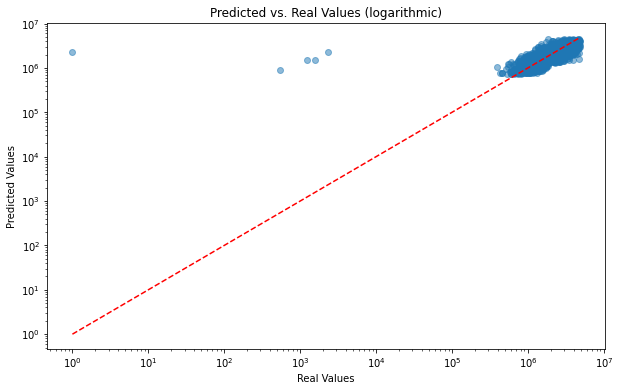

In [48]:
with torch.no_grad():
    
    y_pred_tensor = model(X_test_tensor)
    y_pred_scaled = y_pred_tensor.numpy().squeeze()


y_pred = scaler_Y.inverse_transform(y_pred_scaled.reshape(-1, 1)).squeeze()
y_test_unscaled = scaler_Y.inverse_transform(Y_test_scaled).squeeze()
r2 = r2_score(y_test_unscaled, y_pred)
print(f"R2 score: {r2:.4f}")

# Plot the predicted vs. real values with logarithmic scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test_unscaled, y_pred, alpha=0.5)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Real Values (logarithmic)")

# Set the scale of the axes to logarithmic
plt.xscale("log")
plt.yscale("log")

# Add a diagonal line to visualize the perfect prediction
max_value = max(max(y_test_unscaled), max(y_pred))
plt.plot([1, max_value], [1, max_value], color="red", linestyle="--")
plt.show()

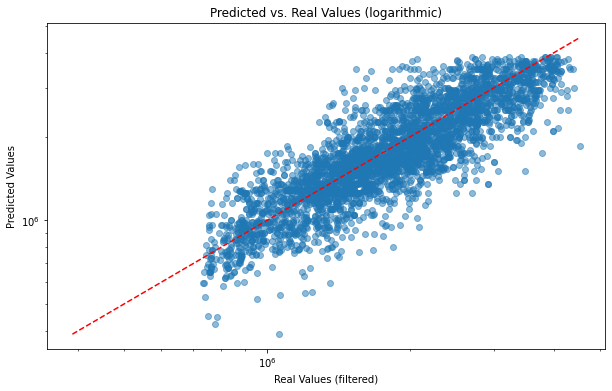

In [49]:
import numpy as np
from scipy import stats
model.eval()




# Calculate the Z-scores for y_test
z_scores = np.abs(stats.zscore(y_test))

# Set a threshold for the Z-score to remove outliers (e.g., 2 standard deviations from the mean)
threshold = 2

# Create a mask to filter out the outliers
mask = (z_scores < threshold)

# Apply the mask to y_test and y_pred_test_lr
y_test_filtered = y_pred[mask]
y_pred_filtered = y_test_unscaled[mask]

# Plot the filtered data with logarithmic scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, y_pred_filtered, alpha=0.5)
plt.xlabel("Real Values (filtered)")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Real Values (logarithmic)")

# Set the scale of the axes to logarithmic
plt.xscale("log")
plt.yscale("log")

# Add a diagonal line to visualize the perfect prediction
min_value_filtered = min(min(y_test_filtered), min(y_pred_filtered))
max_value_filtered = max(max(y_test_filtered), max(y_pred_filtered))
plt.plot([min_value_filtered, max_value_filtered], [min_value_filtered, max_value_filtered], color="red", linestyle="--")

plt.show()

In [50]:
xgb = xg.XGBRegressor()

param_grid = {
'n_estimators': [1000],
'learning_rate': [0.01],
'max_depth': [5,6,7,8],
'min_child_weight': [1,3,5],
'subsample': [0.5,1.0],
'colsample_bytree': [0.5, 1.0],
'gamma': [ 0.1, 0.2],
'reg_alpha': [0.1,0.2,0.5],
'reg_lambda': [1, 2],
"early_stopping_rounds":[20]
}


grid_search = GridSearchCV(
estimator=xgb,
param_grid=param_grid,
scoring='neg_mean_squared_error',
n_jobs=-1,
cv=2,
verbose=4
)


grid_search.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)       
best_model = grid_search.best_estimator_    

best_model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=False)
y_pred_train_lr = best_model.predict(X_train)
y_pred_test_lr = best_model.predict(X_test)
mse_test_lr = MSE(y_test, y_pred_test_lr)
r2 = r2_score(y_test, y_pred_test_lr)

print(f"R2 score  : {r2}")


Fitting 2 folds for each of 576 candidates, totalling 1152 fits
R2 score  : 0.812904533907695


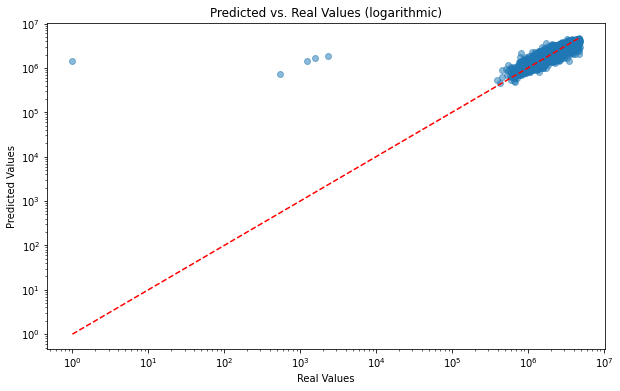

In [51]:


# Plot the predicted vs. real values with logarithmic scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test_lr, alpha=0.5)
plt.xlabel("Real Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Real Values (logarithmic)")

# Set the scale of the axes to logarithmic
plt.xscale("log")
plt.yscale("log")

# Add a diagonal line to visualize the perfect prediction
min_value = min(min(y_test), min(y_pred_test_lr))
max_value = max(max(y_test), max(y_pred_test_lr))
plt.plot([min_value, max_value], [min_value, max_value], color="red", linestyle="--")

plt.show()

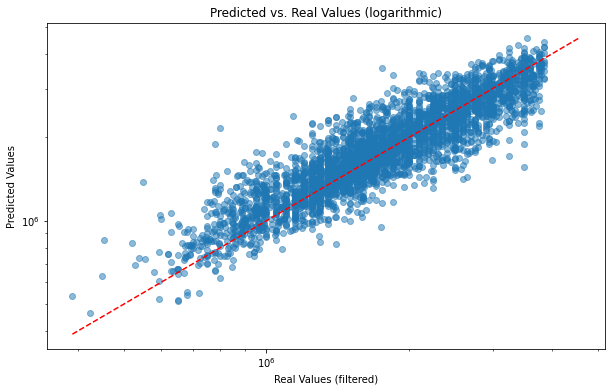

In [33]:
import numpy as np
from scipy import stats

# Calculate the Z-scores for y_test
z_scores = np.abs(stats.zscore(y_test))

# Set a threshold for the Z-score to remove outliers (e.g., 2 standard deviations from the mean)
threshold = 2

# Create a mask to filter out the outliers
mask = (z_scores < threshold)

# Apply the mask to y_test and y_pred_test_lr
y_test_filtered = y_test[mask]
y_pred_filtered = y_pred_test_lr[mask]

# Plot the filtered data with logarithmic scale
plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, y_pred_filtered, alpha=0.5)
plt.xlabel("Real Values (filtered)")
plt.ylabel("Predicted Values")
plt.title("Predicted vs. Real Values (logarithmic)")

# Set the scale of the axes to logarithmic
plt.xscale("log")
plt.yscale("log")

# Add a diagonal line to visualize the perfect prediction
min_value_filtered = min(min(y_test_filtered), min(y_pred_filtered))
max_value_filtered = max(max(y_test_filtered), max(y_pred_filtered))
plt.plot([min_value_filtered, max_value_filtered], [min_value_filtered, max_value_filtered], color="red", linestyle="--")

plt.show()